In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import glob
import tensorflow as tf

### Классификация изображкний с использованием tf, cifar10.

#### Загрузка cifar10 из локальной директории

In [8]:
batch_size = 32
images = tf.keras.utils.image_dataset_from_directory('/tf/notebooks/data/cifar10/images',image_size = (32,32), batch_size=batch_size)


Found 10000 files belonging to 10 classes.


In [9]:
class_names = images.class_names
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

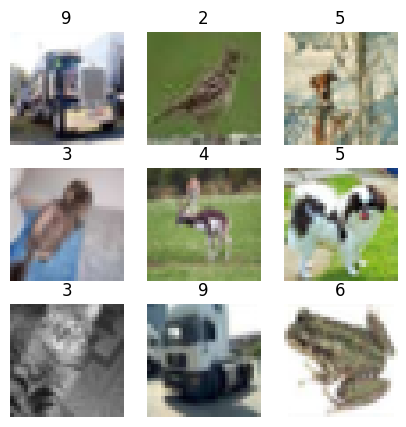

In [10]:
plt.figure(figsize=(5,5))
for im, lb in images.take(1):
    
    for i in range(9):
        ax= plt.subplot(3,3,i+1)
        
        plt.imshow(im[i].numpy().astype("uint8"))
        plt.title(class_names[lb[i]])
        plt.axis("off")


In [11]:
# dataset = tf.data.Dataset.range(100)
# train_size = 70
# test_size = 15
# valid_size = 15
# dataset = dataset.shuffle(buffer_size=100)
# train_dataset = dataset.take(train_size)
# test_dataset = dataset.skip(train_size)
# valid_dataset = test_dataset.skip(valid_size)
# test_dataset = test_dataset.take(test_size)

In [12]:
# for i in test_dataset:
#     print(i)

In [13]:
dataset = images

#Размеры выборок
train_size = int(0.7*len(dataset))
test_size = int(0.15*len(dataset))
valid_size = int(0.15*len(dataset))

#Делим на train, test и valid
dataset = dataset.shuffle(buffer_size=100)

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(test_size)
valid_dataset = test_dataset.skip(valid_size)
test_dataset = test_dataset.take(test_size)


#### Подготовка данных

In [14]:
NUM_EPOCHS = 20
train_dataset = train_dataset.repeat(NUM_EPOCHS)


#### Создание простой модели

In [15]:
class Model(tf.keras.Model):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(32, (5,5), activation='relu', padding='same')
        self.conv2 = tf.keras.layers.Conv2D(64, (5,5), activation='relu', padding='same')
        self.fc1 = tf.keras.layers.Dense(256, activation='relu')
        self.fc2 = tf.keras.layers.Dense(10, activation=None)
        self.max_pool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2))
        self.flatten = tf.keras.layers.Flatten()
        
    def call(self, inp):
        
        out = self.conv1(inp)
        out = self.max_pool(out)
        out = self.conv2(out)
        out = self.max_pool(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out
    
model = Model()

In [16]:
#model.summary()

In [17]:
??tf.keras.layers.Conv2D

In [18]:
def loss(logits, labels):
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=labels))

def accuracy(logits, labels):
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    return tf.reduce_mean(tf.cast(tf.equal(predictions, labels), dtype=tf.float32))


In [19]:

LEARNING_RATE = 0.001

# optimizer = tf.keras.optimizers.SGD(LEARNING_RATE)
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

# writer = tf.summary.create_file_writer('logs/sgd')
writer = tf.summary.create_file_writer('logs/adam')


In [20]:
%%time

for iteration, (images, labels) in enumerate(train_dataset):
    
    #print(labels)
    # Forward
    with tf.GradientTape() as tape:
        logits = model(images)
        loss_value = loss(logits, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
#     # Calc and display loss/accuracy
    if iteration % 200 == 0:
        
        accuracy_value = 0
        for test_x, test_y in test_dataset:
            test_logits = model(test_x)
            accuracy_value += accuracy(test_logits, test_y)
            
        accuracy_value = accuracy_value/len(test_dataset)
        
        print("[%4d] Accuracy: %5.2f %%" % (
               iteration, accuracy_value.numpy()*100))
        
        with writer.as_default():
            tf.summary.scalar('accuracy', accuracy_value, iteration)
            tf.summary.scalar('loss', loss_value, iteration)


[   0] Accuracy: 11.01 %
[ 200] Accuracy: 24.05 %
[ 400] Accuracy: 29.82 %
[ 600] Accuracy: 38.11 %
[ 800] Accuracy: 42.19 %
[1000] Accuracy: 50.20 %
[1200] Accuracy: 59.17 %
[1400] Accuracy: 59.44 %
[1600] Accuracy: 66.44 %
[1800] Accuracy: 70.52 %
[2000] Accuracy: 75.27 %
[2200] Accuracy: 77.85 %
[2400] Accuracy: 78.67 %
[2600] Accuracy: 80.64 %
[2800] Accuracy: 87.91 %
[3000] Accuracy: 87.84 %
[3200] Accuracy: 89.95 %
[3400] Accuracy: 93.75 %
[3600] Accuracy: 91.51 %
[3800] Accuracy: 92.93 %
[4000] Accuracy: 93.75 %
[4200] Accuracy: 86.82 %
CPU times: user 1min 9s, sys: 5.57 s, total: 1min 14s
Wall time: 42.3 s


### Проверяем работу модели на valid_dataset

In [23]:
%%time

accuracy_value = 0
for test_x, test_y in valid_dataset:
    test_logits = model(test_x)
    accuracy_value += accuracy(test_logits, test_y)

accuracy_value = accuracy_value/len(valid_dataset)
print("Final Accuracy: %5.2f %%" % (accuracy_value * 100))        
        

Final Accuracy: 79.60 %
CPU times: user 1.4 s, sys: 211 ms, total: 1.61 s
Wall time: 644 ms


In [61]:
def test_item(im, logits):
    
    #logits = model(sample[None, ...])[0]
    prediction = tf.nn.softmax(logits[0])
    #print(prediction)
    ans = np.argmax(prediction)
    
    fig = plt.figure(figsize=(12,4))

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(im.numpy().astype("uint8"))
    plt.xticks([]), plt.yticks([])

    ax = fig.add_subplot(1, 2, 2)
    bar_list = ax.bar(np.arange(10), prediction, align='center')
    bar_list[ans].set_color('g')
    ax.set_xticks(np.arange(10))
    ax.set_xlim([-1, 10])
    ax.grid(True)

    plt.show()
    
    print('Predicted: {}'.format(ans))

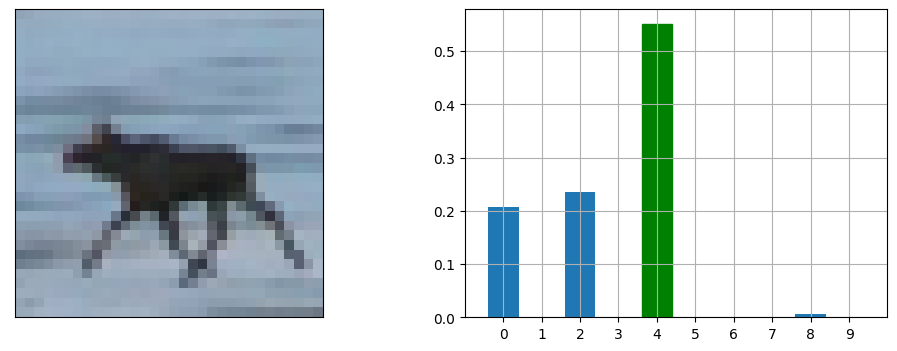

Predicted: 4


In [66]:
for test_x, test_y in valid_dataset:
    test_logits = model(test_x)
    test_item(test_x[0], test_logits)
    
    break


In [64]:
# %load_ext tensorboard
# %tensorboard --logdir logs